This notebook can be launched using the Docker image of CoLoMoTo:
    $docker pull colomoto/colomoto-docker:2018-03-31

or by creating a conda environment wuth the following command:
    $conda create -n prostate -c colomoto ginsim-python pymaboss -c potassco
    
To launch this notebook, type the command:
    $jupyter notebook

In [1]:
# Set up working environment
import maboss
import biolqm
import ginsim
import numpy as np

from colomoto_jupyter import tabulate
from itertools import combinations
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.stats import norm
from random import shuffle
from scipy.interpolate import CubicSpline
from scipy.integrate import quad
from scipy.integrate import quad_explain

In [98]:
bnd_file = "model5.bnd"
cfg_WT = "model5edit.cfg"
WT = maboss.load(bnd_file, cfg_WT)

In [4]:
#define functions
def getExitTimes(run, N): # turn CDF from MaBoSS into PDF
    tc = run.get_nodes_probtraj()
    tc2 = tc["ME"].tolist() # get time course as a list 
    tcT = tc.index.tolist()
    dt = tcT[1]-tcT[0]
    diff = (np.asarray(tc2[2:len(tc2)])-np.asarray(tc2[1:(len(tc2)-1)]))/dt# get difference between tc points
    mids = (np.asarray(tcT[2:len(tcT)])+np.asarray(tcT[1:(len(tcT)-1)]))/2
    diff_red = list()
    mids_red = list()
    n = len(tc2)
    k = int(n/N)
    for i in range(0,k):
        diff_red.append(np.mean(diff[N*i:N*i+N]))
        mids_red.append(np.mean(mids[N*i:N*i+N]))
    return(np.array([mids_red, diff_red]))

def exit2Av(mids,diff): # estimate mean from PDF
    dt = mids[1]-mids[0]
    Av = sum(mids*diff)*dt
    return(Av)

In [103]:
WT = maboss.copy_and_update_parameters(WT, {'max_time':150}) # set max time
WT = maboss.copy_and_update_parameters(WT, {'sample_count':10000}) # set number of cells to simulate

WTLA = WT.copy() # make wild type late anaphase model
WTLA.network.set_istate("SpindleAlign", [0,1]) # set spindle alignment to ON
WTLA.network.set_istate("SACA_Nucleus", [1,0]) # set SAC activity OFF (anaphase)

mut_Spo12_OFF_LA = WTLA.copy() # make spo12 delete model
for name in "Spo12L_Nucleus Spo12L_Cytoplasm Spo12L_Bud Spo12L_Nucleolus".split(' '):
    mut_Spo12_OFF_LA.mutate(name, "OFF")
    
    

In [104]:
run_WT_LA = WTLA.run() # run simulations
run_Spo12_OFF_LA = mut_Spo12_OFF_LA.run()

exits_WT = getExitTimes(run_WT_LA,5)
exits_Spo12 = getExitTimes(run_Spo12_OFF_LA,5)


In [105]:
normF = exit2Av(exits_WT[0,:], exits_WT[1,:])
exits_WT_norm = np.array([exits_WT[0,:]/normF,exits_WT[1,:]*normF])
exits_Spo12_norm = np.array([exits_Spo12[0,:]/normF,exits_Spo12[1,:]*normF])

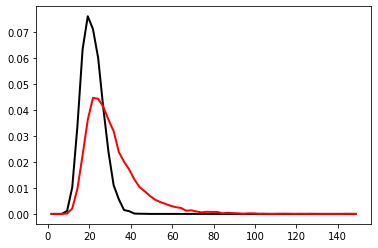

In [106]:
plt.plot(exits_WT[0,:], exits_WT[1,:], linewidth = 2, color = "k")
plt.plot(exits_Spo12[0,:], exits_Spo12[1,:], linewidth = 2, color = "r")


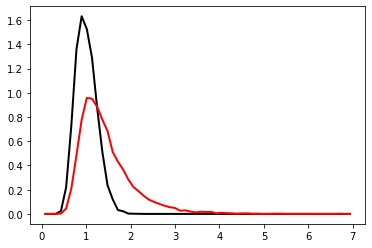

In [107]:
plt.plot(exits_WT_norm[0,:], exits_WT_norm[1,:], linewidth = 2, color = "k")
plt.plot(exits_Spo12_norm[0,:], exits_Spo12_norm[1,:], linewidth = 2, color = "r")


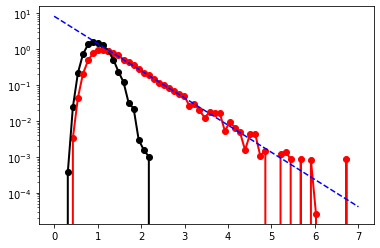

In [108]:
plt.plot(exits_WT_norm[0,:], exits_WT_norm[1,:], linewidth = 2, color = "k")
plt.plot(exits_Spo12_norm[0,:], exits_Spo12_norm[1,:], linewidth = 2, color = "r")
plt.scatter(exits_WT_norm[0,:], exits_WT_norm[1,:], color = "k")
plt.scatter(exits_Spo12_norm[0,:], exits_Spo12_norm[1,:], color = "r")
plt.yscale('log')

index_nz = np.where(exits_Spo12_norm[1,:]!=0)
x_nz = exits_Spo12_norm[0,index_nz[0][slice(9, -1)]]
y_nz = exits_Spo12_norm[1,index_nz[0][slice(9, -1)]]


plt.plot(np.array([0,7]), np.e**np.poly1d(np.polyfit(x_nz, np.log(y_nz), 1))(np.array([0,7])), color = 'b', linestyle = 'dashed')